<a href="https://colab.research.google.com/github/gubrx/eBSDE/blob/main/Forward_deep_ebsde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive_import

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
from tensorflow.keras import  optimizers

from scipy.integrate import quad
#from scipy.interpolate import interp1d
import scipy

# Networks

In [ ]:
#Neural Network
class Net( tf.keras.Model):
    def __init__( self, lambda_lim, ndimOut, nbNeurons, lambd_ex, activation= tf.nn.tanh):
        super().__init__()
        self.nbNeurons = nbNeurons
        self.name_ = "FeedForward"
        self.ndimOut = ndimOut
        #Liste de 20 neurones avec chaucun 2 hidden layers
        self.ListOfDense =  [layers.Dense( nbNeurons[i],activation= activation, kernel_initializer= tf.keras.initializers.GlorotNormal())  for i in range(len(nbNeurons)) ]+[layers.Dense(self.ndimOut, activation= None, kernel_initializer= tf.keras.initializers.GlorotNormal())]
        self.lambd= tf.Variable(tf.keras.initializers.GlorotNormal()([1]),  trainable = True, dtype=tf.float32, constraint=lambda t: tf.clip_by_value(t, -lambda_lim, lambda_lim))
        #self.lambd= tf.Variable(tf.constant([lambd_ex], dtype=tf.float32),  trainable = False, dtype=tf.float32, constraint=lambda t: tf.clip_by_value(t, -lambda_lim, lambda_lim))


    def call(self,inputs):
        x = inputs
        for layer in self.ListOfDense:
            x = layer(x)
        return [x[:,i] for i in range(self.ndimOut)]

# stochasticfactor

In [ ]:
class StochasticFactor:
  def __init__(self, T, T_H, N, mu, sigma, Cv, x0, K):
        self.K = K

        self.Cv = Cv
        self.N = N  # steps number
        self.dt = T/N  # steps length
        self.T_H = T_H

  # initialize
  def init(self, batchSize):
      self.batchSize = batchSize
      return self.x0 * tf.ones([batchSize])

  def first_tps_retour_v(self, T_H, X, num_sample):
      #premier tps retour après T_H
      L = X - self.x0*np.ones([self.K*self.N + 1, num_sample])
      T_A = []
      for i in range(num_sample):
          jstart = round(T_H/self.dt)
          j = round(T_H/self.dt)
          if L[jstart, i] > 0:
              while j < self.K*self.N + 1 and L[j, i] > 0:
                  j = j+1

          else:
              while j < self.K*self.N + 1 and L[j, i] < 0:
                  j = j+1

          if j < self.K*self.N + 1:
              T_A.append(j*self.dt)
          else:
              T_A.append(j*self.dt)

      return T_A


  # Fonction sample diffusion avec condition dissipativité
  def sample(self, num_sample):
      dw_sample = np.random.normal(
          size=[self.K*self.N, num_sample]) * np.sqrt(self.dt)
      x_sample = np.zeros([self.K*self.N + 1, num_sample])
      x_sample[0, :] = np.ones(num_sample) * self.x0
      for i in range(self.K*self.N):
          x_sample[i+1, :] = x_sample[i, :] - self.mu * \
              x_sample[i, :]*self.dt + self.sig*dw_sample[i, :]
      return dw_sample, x_sample


class ErgodicFactorModel(StochasticFactor):
    def __init__(self, T, T_H, N, mu, sigma, Cv, x0, K):
        super().__init__(T, T_H, N, mu, sigma, Cv, x0, K)
        self.T = T  # Maturity

        self.mu = mu  # drift V
        self.sig = sigma  # vol V


        self.x0 = x0  # current price asset
        self.Y0 = (self.Cv/(self.mu + (1/2)*self.sig**2))*np.sqrt(2*np.pi)/2
        self.Zlim = self.sig*(self.Cv / (mu - self.Cv))

    #SOLUTION EXACTE
    def integrand(self, y):
        return tf.exp(-y**2/2)

    # BS closed formula
    def y(self, iStep, X):
        return (self.Cv/(self.mu + (1/2)*self.sig**2))*np.sqrt(2*np.pi)*scipy.stats.norm.cdf(X[iStep, :], 0, 1)

    def z(self, iStep, X, num_sample):
        return [self.sig*tf.exp(-X[iStep, m]**2/2) for m in range(num_sample)]

    def erg_sol(self):
        return 0

    # Driver
    def f(self, v, z):
        return v*self.Cv*tf.exp(-v**2/2)

    def lambdlim(self):
        val = max(self.f(1, 0), self.f(-1, 0))
        print('lambdlim=', val)
        return val

    # Payoff
    def g(self, X):
        return self.Y0 * tf.ones([tf.shape(X)[0]])

    def lambdlin(self, Nbsimul):
      dW, X = self.sample(Nbsimul)
      T_R =  self.first_tps_retour_v(self.T_H, X, Nbsimul)
      indTR = [round(elt/self.dt) for elt in T_R]
      meanT_R = (1/Nbsimul)*sum(T_R)
      appint = [sum([self.dt*self.f(X[t, m], 0) for t in range(indTR[m]-1)]) for m in range(Nbsimul)]
      meanappint = (1/Nbsimul)*sum(appint)

      return float(meanappint / meanT_R)


class ErgodicFactorModelNZ(StochasticFactor):
    def __init__(self, T, T_H, N, mu, sigma, Cv, x0, K):
        super().__init__(T, T_H, N, mu, sigma, Cv, x0, K)
        self.mu = mu #CONDITION mu > Cv
        self.sig = np.sqrt(2*self.mu)

        self.A1 = self.Cv/(self.sig**2)
        self.A2 = 2*self.A1

        self.x0 = x0  #initial value diffusion
        self.Y0 = quad(lambda y: np.exp(y**2/2)*(self.A1*np.exp(-y**2) + self.A2*(scipy.stats.norm.cdf(y, 0, 1) - 1)), 0, x0)[0]

        self.Zlim = self.sig*(self.Cv / (mu - self.Cv))
        print('Zlim=', self.Zlim)
        print('A1=', self.A1)
        print('A2=', self.A2)


    #SOLUTION EXACTE

    def integrandpos(self, y):
        return np.exp(y**2/2)*(self.A1*np.exp(-y**2) + self.A2*(scipy.stats.norm.cdf(y, 0, 1) - 1))

    def integrandneg(self, y):
        return np.exp(y**2/2)*(-self.A1*np.exp(-y**2) + self.A2*scipy.stats.norm.cdf(y, 0, 1))

    def y(self, iStep, X):
        num_var=len(X[0, :])
        FTR = mathModel.first_tps_retour_v(T_H, X, len(X[0,:]))
        listM = [int(iStep <= round(FTR[m]/mathModel.dt)) for m in range(nbr_traj)]

        Neg = np.array([int(X[iStep, m] < 0) for m in range(num_var)])
        Pos = np.array([int(X[iStep, m] >= 0) for m in range(num_var)])
        Xpos = X[iStep, :] * Pos * listM
        Xneg = X[iStep, :] * Neg * listM

        Xpos = np.array([quad(self.integrandpos, 0, Xpos[m])[0]
                for m in range(num_var)])
        Xneg = np.array([quad(self.integrandneg, 0, Xneg[m])[0]
                for m in range(num_var)])
        #cannot be easily vectorized / use of quadvec deprecated

        return Pos*Xpos + Neg*Xneg

    # Driver
    def f(self, v, z):
        return self.Cv*abs(v)*tf.exp(-v**2/2)

    def lambdlim(self):
        val = max(self.f(1, 0), self.f(-1, 0))
        print('lambdlim=', val)
        return val

    def erg_sol(self):
        return self.Cv / np.sqrt(2*np.pi)

    # Payoff
    def g(self, X):
        return self.Y0 * tf.ones([tf.shape(X)[0]])

    def lambdlin(self, Nbsimul):
      dW, X = self.sample(Nbsimul)
      T_R =  self.first_tps_retour_v(self.T_H, X, Nbsimul)
      indTR = [round(elt/self.dt) for elt in T_R]
      meanT_R = (1/Nbsimul)*sum(T_R)
      appint = [sum([self.dt*self.f(X[t, m], 0) for t in range(indTR[m]-1)]) for m in range(Nbsimul)]
      meanappint = (1/Nbsimul)*sum(appint)

      return float(meanappint / meanT_R)



# SolvereBSDEback_opt

In [ ]:
class SolverBase:
    # mathModel          Math model
    # modelKeras         Keras model
    # lRate              Learning rate
    def __init__(self, mathModel, modelKerasUZ , lRate, lambdRate):
        # to store les different networks
        self.mathModel = mathModel
        self.modelKerasUZ = modelKerasUZ
        self.lRate = lRate
        self.lambdRate = lambdRate

class SolverGlobaleBSDE(SolverBase):
    def __init__(self, mathModel, modelKerasUZ , lRate, lambdRate):
        super().__init__(mathModel, modelKerasUZ , lRate, lambdRate)

    def tronc(self, X, xlim):
        Inf = tf.cast(X < -xlim, tf.float32)
        Sup = tf.cast(X > xlim, tf.float32)
        Born = 1.0 - Inf - Sup

        return (Inf * (-xlim)) + (Sup * xlim) + (Born * X)

    def train(self,  batchSize,  batchSizeVal, num_epoch, num_epochExt):
        @tf.function
        def optimizeBSDE(nbSimul):
            # Initialize
            dW, X = self.mathModel.sample(nbSimul)
            T_P =  self.mathModel.first_tps_retour_v(self.mathModel.T_H, X, nbSimul)
            indTP = [round(elt/self.mathModel.dt) for elt in T_P]

            dW, X = tf.convert_to_tensor(dW, dtype=tf.float32), tf.convert_to_tensor(X, dtype=tf.float32)

            # Target
            Y = []
            maxind = max(indTP)
            print(maxind)
            print('first_return_time =', indTP)

            Y_trans = self.mathModel.Y0 * tf.ones([nbSimul], dtype=tf.float32)
            Y_prov=[]
            Y_init = self.mathModel.Y0 * tf.ones([nbSimul], dtype=tf.float32)
            for iStep in range(maxind):
                Z = self.tronc(self.modelKerasUZ(tf.stack([iStep*tf.ones([nbSimul], dtype=tf.float32), X[iStep, :]], axis=-1))[0], self.mathModel.Zlim)
                Y_trans = Y_trans - self.mathModel.dt * tf.transpose(self.mathModel.f(X[iStep, :], Z)) + self.modelKerasUZ.lambd * tf.ones([nbSimul], dtype=tf.float32) * self.mathModel.dt + Z * tf.transpose(dW[iStep, :])
                indices = tf.where(tf.equal(indTP, iStep))[:, 0]
                Y_trans_selected = tf.gather(Y_trans, indices)
                Y.append(Y_trans_selected)

            Y = tf.concat(Y, axis=0)
            print('Ytest=', Y)

            return tf.reduce_mean(tf.square(Y - self.mathModel.Y0))

        # train to optimize control
        @tf.function
        def trainOptNN( nbSimul,optimizer):
            with tf.GradientTape() as tape:
                objFunc_Z = optimizeBSDE( nbSimul)
            gradients = tape.gradient(objFunc_Z, self.modelKerasUZ.ListOfDense.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.modelKerasUZ.ListOfDense.trainable_variables))
            return objFunc_Z

        # train to optimize control
        @tf.function
        def trainOptLam( nbSimul,optimizer):
            with tf.GradientTape() as tape:
                objFunc_Z = optimizeBSDE( nbSimul)
            gradients = tape.gradient(objFunc_Z, [self.modelKerasUZ.lambd])
            optimizer.apply_gradients(zip(gradients, [self.modelKerasUZ.lambd]))
            return objFunc_Z


        optimizerN = optimizers.Adam(learning_rate = self.lRate)
        optimizerL = optimizers.Adam(learning_rate = self.lambdRate)

        self.listlambd = []
        self.lossList = []
        self.duration = 0
        for iout in range(num_epochExt):
            start_time = time.time()
            for epoch in range(num_epoch):
                # un pas de gradient stochastique
                trainOptNN(batchSize, optimizerN)
                trainOptLam(batchSize, optimizerL)
            end_time = time.time()
            rtime = end_time-start_time

            self.duration += rtime
            objError_Yterm = optimizeBSDE(batchSizeVal)
            lambd = self.modelKerasUZ.lambd.numpy()
            print(" Error",objError_Yterm.numpy(),  " elapsed time %5.3f s" % self.duration, "lambda so far ",lambd, 'epoch', iout)
            self.listlambd.append(lambd)
            self.lossList.append(objError_Yterm)


        return self.listlambd, self.lossList

# main_erg

Zlim= 2.1081851067789192
A1= 0.3125
A2= 0.625
l= 0.19947114020071635
lambdlim= tf.Tensor(0.30326533, shape=(), dtype=float32)
588
first_return_time = [26, 11, 119, 32, 16, 13, 19, 12, 27, 11, 57, 16, 25, 17, 11, 36, 15, 63, 22, 11, 11, 13, 56, 25, 64, 79, 17, 22, 124, 14, 63, 35, 12, 15, 12, 11, 14, 13, 36, 106, 18, 20, 79, 12, 13, 25, 25, 22, 23, 23, 12, 18, 43, 20, 207, 114, 12, 25, 28, 120, 23, 13, 80, 127, 13, 13, 148, 207, 33, 12, 75, 17, 27, 19, 18, 14, 15, 28, 16, 108, 20, 14, 17, 40, 28, 100, 210, 68, 23, 13, 25, 156, 66, 12, 58, 15, 240, 45, 21, 43, 30, 19, 13, 13, 17, 21, 24, 11, 44, 11, 61, 19, 20, 71, 14, 18, 13, 11, 66, 30, 17, 33, 88, 74, 136, 23, 15, 24, 24, 11, 25, 17, 137, 148, 13, 12, 63, 15, 32, 28, 15, 21, 15, 12, 14, 27, 22, 23, 11, 19, 12, 23, 19, 43, 88, 78, 59, 16, 24, 14, 53, 21, 57, 77, 11, 32, 26, 83, 62, 45, 11, 46, 15, 12, 167, 43, 11, 13, 375, 187, 37, 30, 37, 24, 15, 100, 16, 43, 33, 15, 101, 107, 44, 184, 14, 75, 35, 19, 30, 77, 64, 50, 13, 25, 12, 16, 3

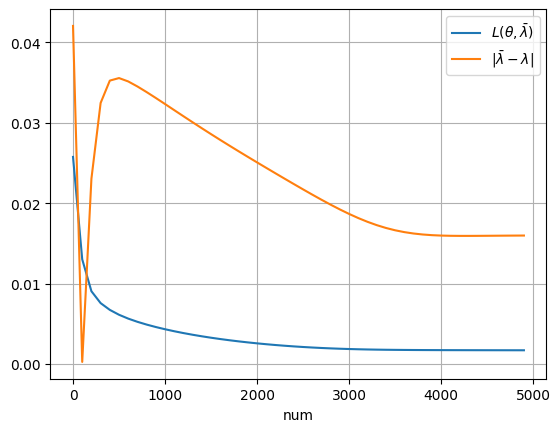

Model: "net_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            multiple                  60        
                                                                 
 dense_25 (Dense)            multiple                  420       
                                                                 
 dense_26 (Dense)            multiple                  420       
                                                                 
 dense_27 (Dense)            multiple                  21        
                                                                 
Total params: 922 (3.60 KB)
Trainable params: 922 (3.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Summary= None


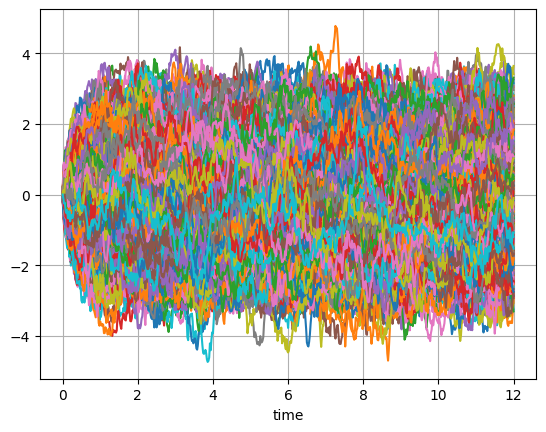

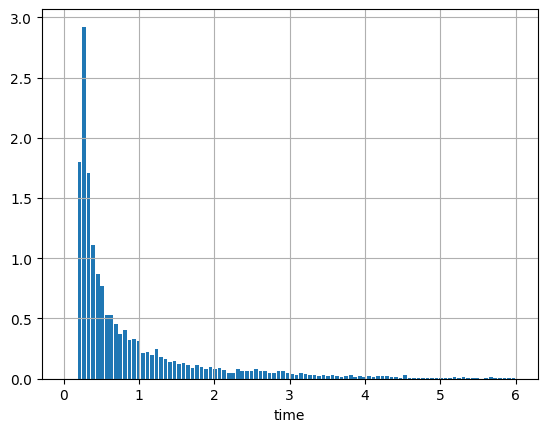

mathModel.Y0= 0.0
0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [ ]:
#PARAMETRES
nbNeuron=20
nbLayer=3
num_epochExt=50
num_epoch=100
batchSize = 5000
lRate =0.00002 #10-4 pour ex2
lambdRate = 0.0007
activation = tf.nn.tanh
M_lim = 5000
K=5

# Layers
######################################
layerSize = nbNeuron*np.ones((nbLayer,), dtype=np.int32)
# parameter models
######################################
dict_parameters = {'T':1, 'T_H': 0.2, 'N':50, 'sig': 1, 'mu' : 2, 'Cv':0.5, 'x0': 0}
T, T_H, N, sig, mu, Cv, x0 = dict_parameters.values()
# Train
#######################################
listLoss = []
listProcesses = []
# math model
##########################
mathModel = ErgodicFactorModelNZ(T, T_H, N, mu, sig, Cv, x0, K)
# lambda value
lamb_ex = mathModel.erg_sol() #valeur exacte
print('l=', lamb_ex)
lambda_lim = mathModel.lambdlim()

ndimOut = 1

kerasModelUZ = Net(lambda_lim, ndimOut, layerSize, lamb_ex, activation)
# solver
#########################
solver = SolverGlobaleBSDE(mathModel, kerasModelUZ , lRate, lambdRate)

Nepoch = range(0, num_epoch*num_epochExt, num_epoch)
# train and  get solution
lambdlist, lossT_Hlist=  solver.train(batchSize,batchSize, num_epoch,num_epochExt )
print('lambdaNN=',kerasModelUZ.lambd.numpy())
# Store loss
listLoss.append(solver.lossList)
plt.plot(Nepoch, lossT_Hlist, label = r'$L(\theta, \bar{\lambda})$')
plt.plot(Nepoch, [abs(lambdlist[i] - mathModel.erg_sol()) for i in range(len(lambdlist))], label = r'$|\bar{\lambda} - \lambda|$')
plt.grid()
plt.legend()
plt.xlabel('num')
plt.show()

#Info NNN
print('Summary=', kerasModelUZ.summary())

######## Print Trajectoires

nbr_traj = 1000
T = np.linspace(0, K*T, K*N+1)
dW, X = mathModel.sample(batchSize)
plt.plot(T, X)
plt.xlabel('time')
plt.grid()
plt.show()


#HIST TPS RETOUR
FTR = mathModel.first_tps_retour_v(T_H, X, len(X[0,:]))
plt.hist(FTR, density = True, range = (0, 6), bins = 100, rwidth = 0.8)
#plt.title('Histogramme normalisé first_tps_retour en v0')
plt.grid()
plt.xlabel('time')
plt.show()

print('mathModel.Y0=', mathModel.Y0)


#Y_EXACT
Y_ex = np.zeros([K*N+1, nbr_traj])
for iStep in range(K*N+1):
  Y_ex[iStep, :] = mathModel.y(iStep, np.reshape(X[:, :nbr_traj], (K*N+1, nbr_traj)))
  print(iStep)
print('y_ex=', Y_ex[0, :])

#Y_SIMUL : on le simule avec une discr forward >> no limitation on time horizon
dW, X = tf.convert_to_tensor(dW, dtype=tf.float32), tf.convert_to_tensor(X, dtype=tf.float32)
print('nbsimul=', nbr_traj)
nbSimul = nbr_traj
# Target
Y_sim = np.zeros([K*N+1, nbr_traj])
Y_trans = mathModel.Y0 * tf.ones([nbSimul], dtype=tf.float32)
maxind = round(max(FTR)/mathModel.dt)-1
print(maxind)
Y_sim[0, :] = Y_trans.numpy()
Y_init = mathModel.Y0 * tf.ones([nbSimul], dtype=tf.float32)
indTP = [round(FTR[sim]/mathModel.dt) for sim in range(nbSimul)]
for iStep in range(maxind):
    Z = solver.tronc(kerasModelUZ(tf.stack([iStep*tf.ones([nbSimul], dtype=tf.float32), X[iStep, :nbSimul]], axis=-1))[0], mathModel.Zlim)
    Y_trans = Y_trans - mathModel.dt * tf.transpose(mathModel.f(X[iStep, :nbSimul], Z)) + kerasModelUZ.lambd * tf.ones([nbSimul], dtype=tf.float32) * mathModel.dt + Z * tf.transpose(dW[iStep, :nbSimul])
    Y_sim[iStep+1, :] = Y_trans.numpy()

print('Y0=', mathModel.Y0)

#PLOT_ERROR
Y_sim_mod = np.zeros([K*N+1, nbr_traj])
indTH = round(T_H/mathModel.dt)
for iStep in range(indTH):
  listM = [int(iStep <= round(FTR[m]/mathModel.dt)) for m in range(nbr_traj)]
  Y_sim_mod[iStep, :] = np.reshape(Y_sim[iStep, :nbr_traj] * listM, (1, nbr_traj))
print(Y_sim)
print(Y_sim_mod)
Etot = abs(Y_ex - Y_sim_mod)
Ered = tf.reduce_sum(Etot, 1).numpy()
cardlist = [sum([int(round(FTR[m]/mathModel.dt) >= i) for m in range(nbr_traj)]) for i in range(len(T))]
print(cardlist)
Emoy=[]
for i in range(len(T)):
  if cardlist[i] != 0:
    Emoy.append(1/cardlist[i]  *Ered[i])
  else:
    Emoy.append(0)
print(Emoy)
plt.plot(T[:indTH], Emoy[:indTH])
plt.xlabel('time')
plt.ylabel('mean absolute error')
plt.grid()
plt.show()


#PLOT_TRAJ
for m in range(20):
  tau = round(FTR[m]/mathModel.dt)
  if tau != K*mathModel.N+1:
    print(m)
    print(Y_sim[tau, m])
    plt.plot(T[:tau+1], Y_ex[:tau+1,m], label=r'$y(\bar{V})$')
    plt.plot(T[:tau+1], Y_sim[:tau+1,m], label=r'$\bar{Y}$')
    plt.xlabel('time')
    plt.grid()
    plt.legend()
    plt.show()
